In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing, tree
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score, mean_absolute_error, confusion_matrix
from sklearn.feature_selection import RFE
from collections import Counter
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import plotly.express as px

## Housing Market During Crisis and Future Outlook

##### This project is meant to review the housing data that stems from recent housing crisis in the United States and hope to identify key patterns that can be used going forward. The potential use cases for a significant finding would hit many sectors of the country, including financial and governmental. Most of the data used will be come from Zillow. However, some extra data and insights will be sourced from govenrment sites

In [40]:
forecast_data = pd.read_csv("forecast.csv")
home_value_data = pd.read_csv("home_value.csv")
mean_days_on_market = pd.read_csv("mean_days_on.csv")
new_construction_data = pd.read_csv("new_construction.csv")
sale_price_data = pd.read_csv("sale_price.csv")
sales_count_data = pd.read_csv("sales_count.csv")

In [41]:
data_list = [forecast_data, home_value_data, mean_days_on_market, new_construction_data, sale_price_data]

for i in data_list:
    print(i.info)

<bound method DataFrame.info of      RegionID  SizeRank       RegionName RegionType StateName    BaseDate  \
0      102001         0    United States    country       NaN  2024-01-31   
1      394913         1     New York, NY        msa        NY  2024-01-31   
2      753899         2  Los Angeles, CA        msa        CA  2024-01-31   
3      394463         3      Chicago, IL        msa        IL  2024-01-31   
4      394514         4       Dallas, TX        msa        TX  2024-01-31   
..        ...       ...              ...        ...       ...         ...   
890    753929       935       Zapata, TX        msa        TX  2024-01-31   
891    394743       936    Ketchikan, AK        msa        AK  2024-01-31   
892    753874       937        Craig, CO        msa        CO  2024-01-31   
893    395188       938       Vernon, TX        msa        TX  2024-01-31   
894    394767       939       Lamesa, TX        msa        TX  2024-01-31   

     2024-02-29  2024-04-30  2025-01-31  
0

In [42]:
def melt_data(df):
        
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [43]:
for i in data_list:
    print(i.shape)

(895, 9)
(895, 294)
(669, 76)
(312, 77)
(616, 196)


### The second step is visualizing the data to get context for the next steps

In [44]:
sales_MC = sale_price_data[:10]

sales_MC = sales_MC.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])


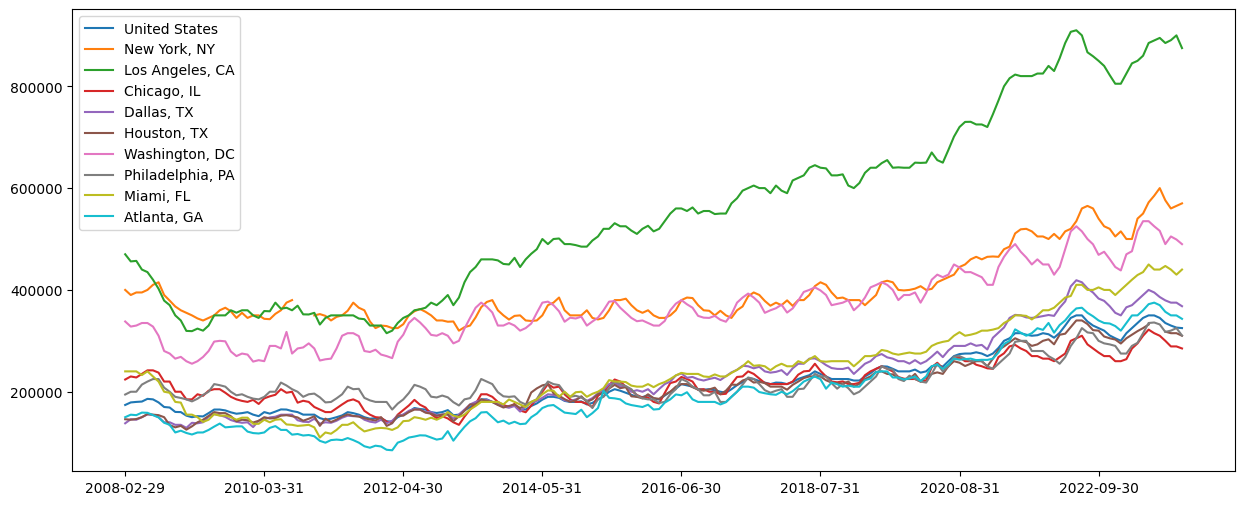

In [45]:

for i in range(len(sales_MC)):
    sales_MC.loc[i, '2008-02-29':].plot(label=sales_MC.loc[i].RegionName, figsize=(15,6))
    plt.legend()


In [46]:
home_value_MC = home_value_data[:10]

home_value_MC = home_value_MC.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])


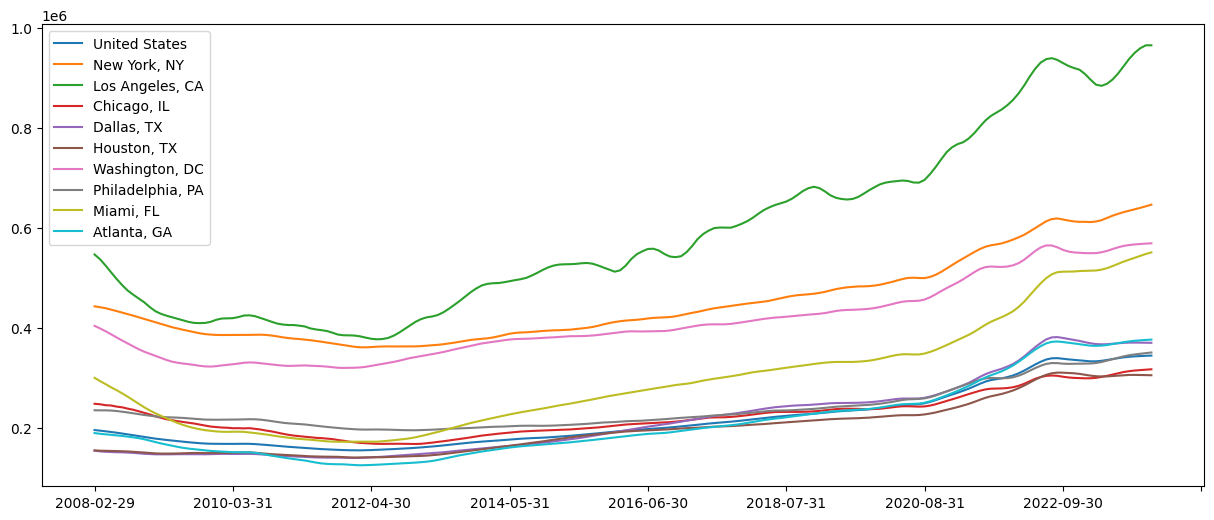

In [47]:
for i in range(len(home_value_MC)):
    home_value_MC.loc[i, '2008-02-29':].plot(label=home_value_MC.loc[i].RegionName, figsize=(15,6))
    plt.legend()

In [48]:
new_construction_data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31
0,102001,0,United States,country,NaN,37120.0,36515.0,46901.0,41666.0,44536.0,...,43248.0,38063.0,43242.0,42658.0,34310.0,37487.0,34248.0,32203.0,31260.0,32911.0
1,394913,1,"New York, NY",msa,NY,520.0,436.0,533.0,503.0,575.0,...,427.0,318.0,432.0,466.0,339.0,436.0,375.0,364.0,339.0,288.0
2,753899,2,"Los Angeles, CA",msa,CA,418.0,430.0,668.0,499.0,520.0,...,230.0,162.0,201.0,218.0,160.0,159.0,177.0,169.0,219.0,193.0
3,394463,3,"Chicago, IL",msa,IL,344.0,345.0,435.0,479.0,560.0,...,492.0,466.0,459.0,501.0,402.0,515.0,432.0,395.0,507.0,362.0
4,394514,4,"Dallas, TX",msa,TX,1502.0,1630.0,2183.0,1920.0,1758.0,...,2222.0,1933.0,2058.0,1974.0,1569.0,1726.0,1511.0,1409.0,1363.0,1619.0


In [49]:
new_con_MC = new_construction_data[1:10]

new_con_MC = new_con_MC.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])

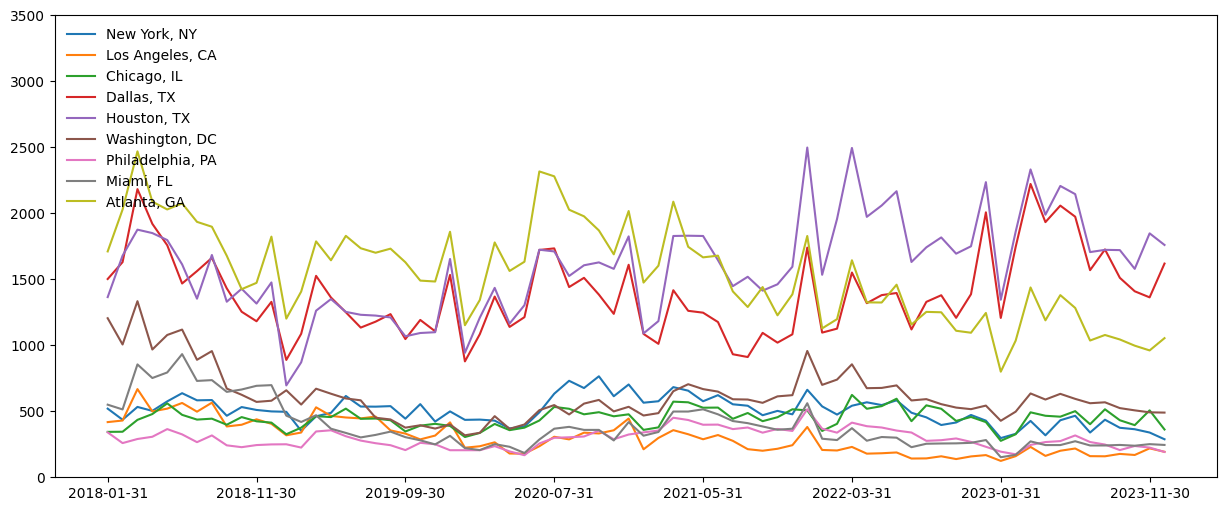

In [50]:
for i in range(len(new_con_MC)):
    new_con_MC.loc[i + 1, '2018-01-31':].plot(label=new_con_MC.loc[i + 1].RegionName, figsize=(15,6))
    plt.legend(loc=2, framealpha = 0)
    plt.ylim(0,3500)

In [51]:
home_value_MC_piv = home_value_MC.T

home_value_MC_piv.head()

,0,1,2,3,4,5,6,7,8,9
RegionName,United States,"New York, NY","Los Angeles, CA","Chicago, IL","Dallas, TX","Houston, TX","Washington, DC","Philadelphia, PA","Miami, FL","Atlanta, GA"
2000-01-31,119228.855824,213153.741396,229681.03428,152972.795463,125458.739107,121816.092151,185230.526634,120872.397467,128982.285567,144047.557766
2000-02-29,119432.242555,214054.665168,230557.577526,153121.315085,125514.227308,121836.189194,185396.44261,121138.350299,129353.406582,144369.304907
2000-03-31,119684.594646,214960.66909,231698.653677,153394.815651,125582.698268,121748.223309,185681.478038,121322.782796,129742.622274,144751.759863
2000-04-30,120226.560248,216793.090703,233972.764899,154075.148928,125756.331962,121802.256266,186332.142907,121774.798566,130523.738019,145567.564185


In [52]:
sales_count_data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
0,102001,0,United States,country,NaN,205003.0,237841.0,263952.0,289885.0,304270.0,...,300173.0,361399.0,383060.0,329179.0,358131.0,310184.0,297774.0,259520.0,247222.0,208542.0
1,394913,1,"New York, NY",msa,NY,8590.0,8966.0,9974.0,10222.0,10847.0,...,10470.0,12440.0,14690.0,13123.0,15222.0,12717.0,12742.0,10764.0,10415.0,9900.0
2,753899,2,"Los Angeles, CA",msa,CA,4156.0,5055.0,6079.0,6899.0,7239.0,...,6044.0,7186.0,7327.0,6229.0,6978.0,5758.0,5800.0,5134.0,4993.0,4387.0
3,394463,3,"Chicago, IL",msa,IL,5920.0,7455.0,7710.0,8385.0,9302.0,...,8628.0,10624.0,11264.0,9663.0,10526.0,8825.0,8427.0,7117.0,7394.0,5213.0
4,394514,4,"Dallas, TX",msa,TX,5054.0,5725.0,6223.0,6907.0,6907.0,...,6501.0,7943.0,7817.0,6895.0,7079.0,5725.0,5328.0,4701.0,4726.0,4305.0


In [53]:
sales_count_MC = sales_count_data[:10]

sales_count_MC = sales_count_MC.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])

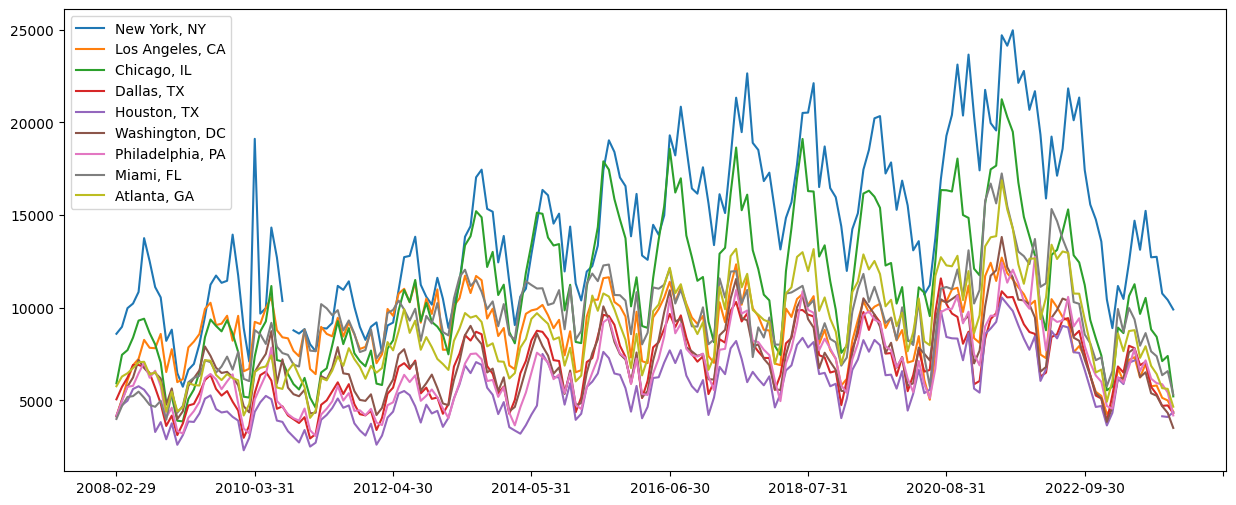

In [54]:
sales_count_cd = sales_count_MC[1:10]
for i in range(len(sales_count_cd)):
    sales_count_cd.loc[i + 1, '2008-02-29':].plot(label=sales_count_cd.loc[i + 1].RegionName, figsize=(15,6))
    plt.legend()

In [55]:
us_sales_cd = sales_count_MC[:1]

us_sales_cd

,RegionName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
0,United States,205003.0,237841.0,263952.0,289885.0,304270.0,307893.0,289689.0,273433.0,264289.0,...,300173.0,361399.0,383060.0,329179.0,358131.0,310184.0,297774.0,259520.0,247222.0,208542.0


<Axes: >

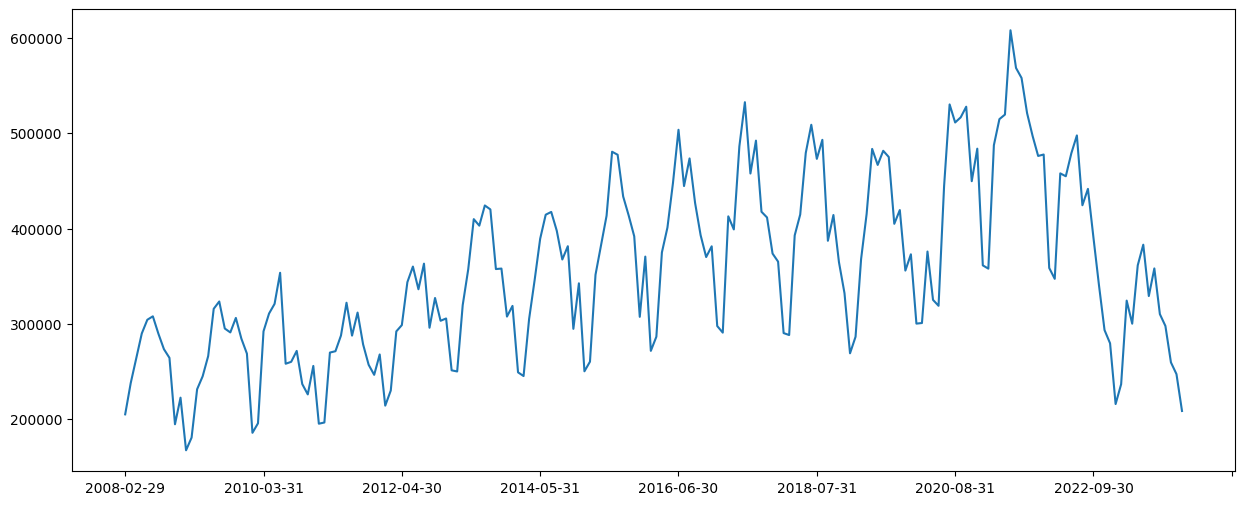

In [56]:
us_sales_cd.loc[0, "2008-02-29":].plot(label=us_sales_cd.loc[0].RegionName, figsize=(15,6))

In [57]:
mean_days_MC = mean_days_on_market[:10]

mean_days_MC = mean_days_MC.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])

mean_days_MC.head()

,RegionName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
0,United States,51.0,48.0,45.0,43.0,44.0,46.0,50.0,54.0,59.0,...,43.0,37.0,33.0,32.0,33.0,35.0,36.0,39.0,44.0,49.0
1,"New York, NY",68.0,65.0,63.0,64.0,66.0,71.0,77.0,82.0,87.0,...,65.0,58.0,54.0,54.0,55.0,56.0,56.0,57.0,61.0,68.0
2,"Los Angeles, CA",35.0,32.0,31.0,32.0,33.0,36.0,40.0,43.0,46.0,...,42.0,35.0,31.0,29.0,29.0,30.0,31.0,33.0,36.0,40.0
3,"Chicago, IL",51.0,44.0,40.0,39.0,40.0,44.0,49.0,54.0,60.0,...,37.0,30.0,26.0,24.0,25.0,26.0,27.0,30.0,36.0,42.0
4,"Dallas, TX",46.0,42.0,38.0,37.0,38.0,41.0,45.0,49.0,54.0,...,37.0,30.0,27.0,28.0,31.0,34.0,37.0,40.0,45.0,51.0


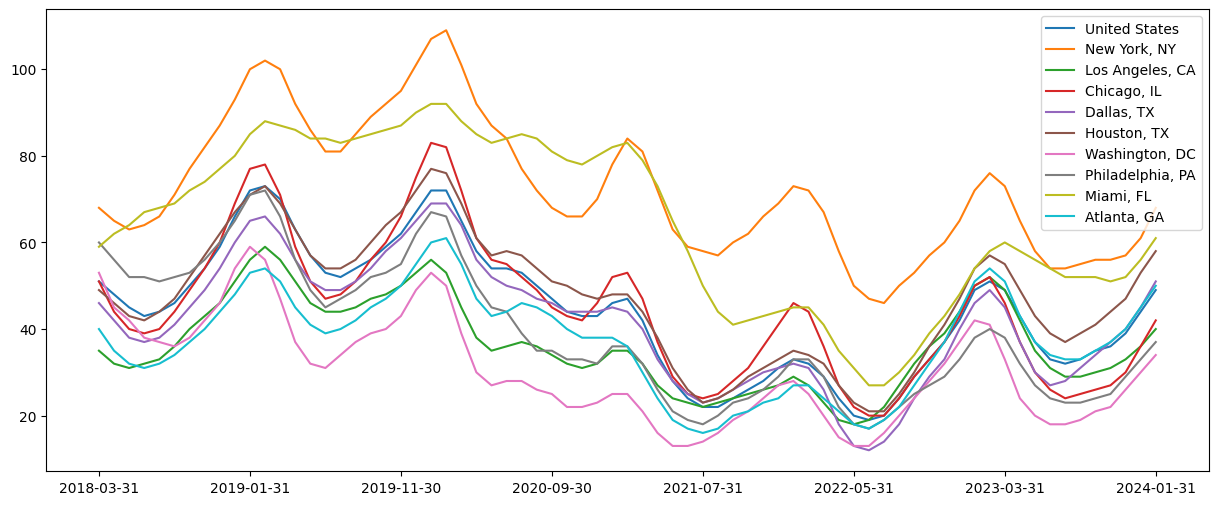

In [58]:
for i in range(len(mean_days_MC)):
    mean_days_MC.loc[i, '2018-03-31':].plot(label=mean_days_MC.loc[i].RegionName, figsize=(15,6))
    plt.legend()

### After checking all the data to evaluate what to use we will build the final dataset

In [59]:
us_sales_count = sales_count_data[:1]
us_sales_price = sale_price_data[:1]
us_home_value = home_value_data[:1]
us_construction = new_construction_data[:1]
us_mean_days = mean_days_on_market[:1]

In [60]:
us_df = pd.DataFrame()
df_list = us_sales_count, us_sales_price, us_home_value, us_construction, us_mean_days

for k in df_list:
    for i in k['RegionName']:
        x = melt_data(k[k['RegionName'] == i])
        us_df = pd.concat([us_df, x], axis = 1)
        # us_df.rename(columns= {'value': f'{k}'}, inplace=True)

us_df

/var/folders/xk/tg0x__xd26g9ykgwhz54qyxh0000gn/T/ipykernel_57411/3520015870.py:4: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/var/folders/xk/tg0x__xd26g9ykgwhz54qyxh0000gn/T/ipykernel_57411/3520015870.py:4: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/var/folders/xk/tg0x__xd26g9ykgwhz54qyxh0000gn/T/ipykernel_57411/3520015870.py:4: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.htm

,value,value,value,value,value
time,,,,,
2000-01-31,NaN,NaN,119228.855824,NaN,NaN
2000-02-29,NaN,NaN,119432.242555,NaN,NaN
2000-03-31,NaN,NaN,119684.594646,NaN,NaN
2000-04-30,NaN,NaN,120226.560248,NaN,NaN
2000-05-31,NaN,NaN,120850.391229,NaN,NaN
...,...,...,...,...,...
2023-09-30,310184.0,335000.0,341554.559455,34248.0,35.0
2023-10-31,297774.0,330000.0,342422.456658,32203.0,36.0
2023-11-30,259520.0,326000.0,343051.457926,31260.0,39.0


In [61]:
def rename_col_by_index(dataframe, index_mapping):
    dataframe.columns = [index_mapping.get(i, col) for i, col in enumerate(dataframe.columns)]
    return dataframe

mapping = {0:'sales count', 1:'sale prices', 2:'home values', 3:'new construction', 4:'mean days'}
us_df = rename_col_by_index(us_df, mapping)

# us_df = us_df.rename(columns={'value':'sale count', 'value':'sale price', 'value':'home value', 'value':'new construction'})

us_df.head()

,sales count,sale prices,home values,new construction,mean days
time,,,,,
2000-01-31,NaN,NaN,119228.855824,NaN,NaN
2000-02-29,NaN,NaN,119432.242555,NaN,NaN
2000-03-31,NaN,NaN,119684.594646,NaN,NaN
2000-04-30,NaN,NaN,120226.560248,NaN,NaN
2000-05-31,NaN,NaN,120850.391229,NaN,NaN


In [62]:
us_df = us_df.dropna(axis=0)

print(us_df.head())
print(us_df.shape)

            sales count  sale prices    home values  new construction  \
time                                                                    
2018-03-31     392798.0     225000.0  218894.711632           46901.0   
2018-04-30     414788.0     228900.0  220122.634771           41666.0   
2018-05-31     479329.0     232500.0  221315.837463           44536.0   
2018-06-30     508935.0     240000.0  222192.118254           42122.0   
2018-07-31     473137.0     235000.0  223289.973115           36280.0   

            mean days  
time                   
2018-03-31       51.0  
2018-04-30       48.0  
2018-05-31       45.0  
2018-06-30       43.0  
2018-07-31       44.0  
(70, 5)


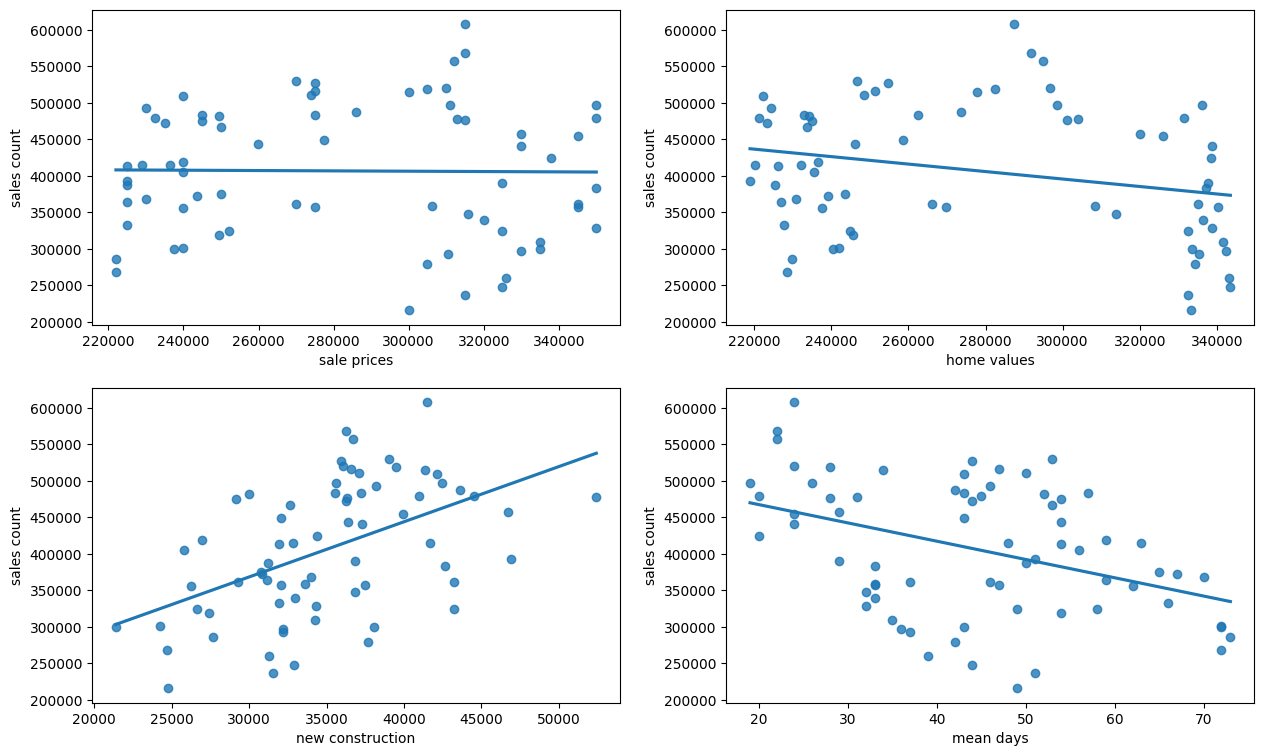

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,9))

sns.regplot(x='sale prices', y='sales count', data = us_df, ci=None, ax=ax1)
# plt.title('Sales Count vs Sale Prices')

sns.regplot(x='home values', y='sales count', data = us_df, ci=None, ax=ax2)
# plt.title('Sales Count vs Home Values')

sns.regplot(x='new construction', y='sales count', data = us_df, ci=None, ax=ax3)
# plt.title('Sales Count vs New Construction')

sns.regplot(x='mean days', y='sales count', data = us_df, ci=None, ax=ax4)
# plt.title('Sales Count vs Mean Days')

plt.show()


### Now we will build the models

<Axes: >

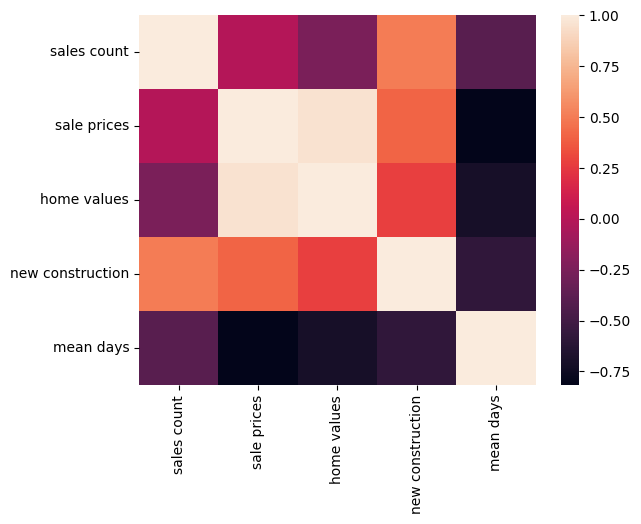

In [64]:
sns.heatmap(us_df.corr())

In [65]:
target = 'sales count'
y = us_df[target]
X = us_df.drop(columns=target)
cut = int(len(X) * 0.6)
X_train, y_train = X.iloc[:cut], y.iloc[:cut]
X_test, y_test = X.iloc[cut:], y.iloc[cut:]

In [66]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print('Mean Sales Count:', round(y_train.mean(), 2))
print('Baseline MAE:', round(mae_baseline, 2))

Mean Sales Count: 431440.33
Baseline MAE: 72483.86


In [67]:
lin_model = LinearRegression()
lin_model = lin_model.fit(X_train, y_train)

lin_model

LinearRegression()

In [68]:
train_mae = mean_absolute_error(y_train, lin_model.predict(X_train))
test_mae = mean_absolute_error(y_test, lin_model.predict(X_test))

print('Training MAE:', round(train_mae, 2))
print('Test MAE:', round(test_mae, 2))

Training MAE: 24032.25
Test MAE: 43885.51


In [69]:
intercept = lin_model.intercept_.round(2)
coef_price = lin_model.coef_.round(2)[0]
coef_value = lin_model.coef_.round(2)[1]
coef_con = lin_model.coef_.round(2)[2]
coef_days = lin_model.coef_.round(2)[3]

print(f"Sales Count = {intercept} + ({coef_price} * Sales Price) + ({coef_value} * Home value) + ({coef_con} * New construction) + ({coef_days} * Mean Days)")

Sales Count = 628083.58 + (5.73 * Sales Price) + (-6.4 * Home value) + (1.17 * New construction) + (-2472.77 * Mean Days)


In [70]:
us_sales_pred = pd.DataFrame(
    {
        'y_test': y_test,
        'y_pred': lin_model.predict(X_test)
    }
)
us_sales_pred

,y_test,y_pred
time,,
2021-09-30,521134.0,489222.024939
2021-10-31,497129.0,478097.488533
2021-11-30,476194.0,480972.832398
2021-12-31,477708.0,460389.195286
2022-01-31,358635.0,366527.425804
2022-02-28,347239.0,394103.204382
2022-03-31,457917.0,455335.803212
2022-04-30,454887.0,506438.146592
2022-05-31,479039.0,511206.839991


In [71]:
fig = px.line(us_sales_pred, labels={'value': 'Sales Count'}, title="Linear Regression Model: Actual Sale Count vs Predicted Sale Count")
fig.show()

#### Based on the graphic above our linear regression model is not exactly accurate point for point. However if it was set to predict future data over the course of a year it would not be wrong to assume the trajectory given the closeness of shape

In [72]:
clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)
clf_en.fit(X_train, y_train)

y_pred_en = clf_en.predict(X_test)

In [73]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.0000


[Text(0.5, 0.875, 'x[3] <= 52.5\nentropy = 5.392\nsamples = 42\nvalue = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1\n1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1\n1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]'),
 Text(0.25, 0.625, 'x[2] <= 36916.0\nentropy = 4.392\nsamples = 21\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0\n1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1\n0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]'),
 Text(0.125, 0.375, 'x[3] <= 45.0\nentropy = 3.322\nsamples = 10\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0\n1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1\n0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]'),
 Text(0.0625, 0.125, 'entropy = 2.322\nsamples = 5\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]'),
 Text(0.1875, 0.125, 'entropy = 2.322\nsamples = 5\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0\n1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1\n0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]'),
 Text(0.

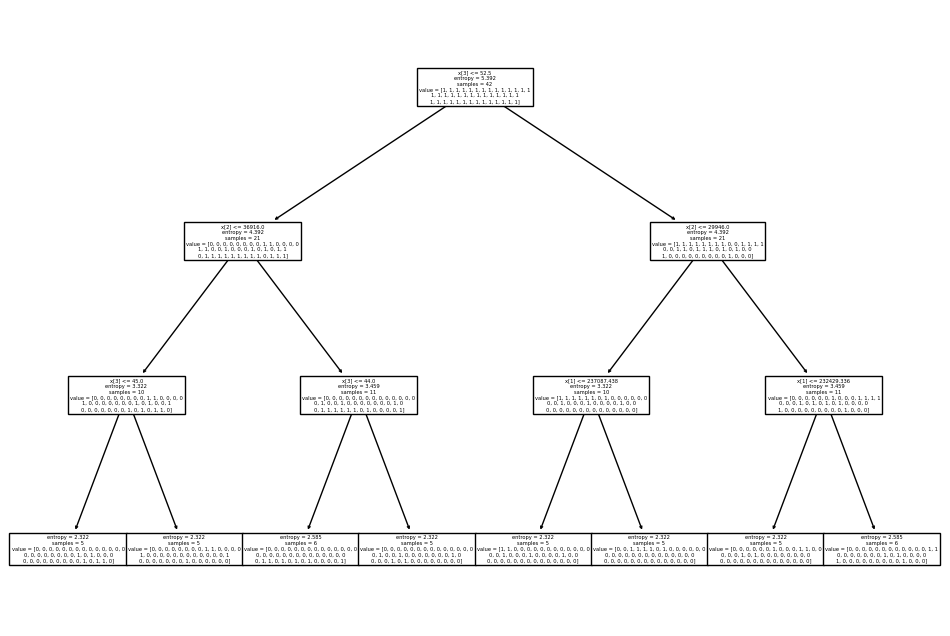

In [74]:
plt.figure(figsize=(12,8))
tree.plot_tree(clf_en.fit(X_train, y_train))

In [75]:
cm = confusion_matrix(y_test, y_pred_en)

print(cm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Results:

#### Based on the multiple models we can tell that the linear model is the best fit and most likely to give true insight to how the data reacts to each other.